This notebook demonstrates how a DAG can be used in combination with the assignment of a distribution to each node and a weight to each edge to create a linear SCM.

In [1]:
import sys
import time
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import normal, uniform

from y0.algorithm.estimation.linear_scm import get_single_door
from y0.dsl import V1, V2, V3, V4, V5, V6, Z1, Z2, X, Y, Z
from y0.examples import backdoor_example, frontdoor_example, napkin_example
from y0.graph import NxMixedGraph
from y0.simulation import example_generators, example_graph, get_fits_df, simulate

/Users/cthoyt/dev/y0/src/y0/examples/__init__.py:1173: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  asia_df = pd.read_csv(ASIA_PATH).replace({"yes": 1, "no": -1})


In [2]:
print(sys.version)

3.12.4 (main, Jun  6 2024, 18:26:44) [Clang 15.0.0 (clang-1500.3.9.4)]


In [3]:
print(time.asctime())

Mon Aug 19 19:06:52 2024


In [4]:
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats("svg")

In [5]:
np.random.seed(42)

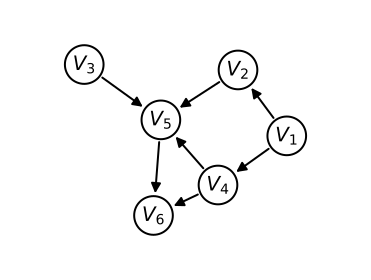

In [6]:
example_graph.draw(prog="neato")

In [7]:
example_graph.to_linear_scm_latex()

'\\begin{align*}{V_{1}} &= \\epsilon_{{V_{1}}} \\\\\n {V_{3}} &= \\epsilon_{{V_{3}}} \\\\\n {V_{2}} &= \\beta_{{V_{1}},{V_{2}}} {V_{1}} + \\epsilon_{{V_{2}}} \\\\\n {V_{4}} &= \\beta_{{V_{1}},{V_{4}}} {V_{1}} + \\epsilon_{{V_{4}}} \\\\\n {V_{5}} &= \\beta_{{V_{2}},{V_{5}}} {V_{2}} + \\beta_{{V_{3}},{V_{5}}} {V_{3}} + \\beta_{{V_{4}},{V_{5}}} {V_{4}} + \\epsilon_{{V_{5}}} \\\\\n {V_{6}} &= \\beta_{{V_{4}},{V_{6}}} {V_{4}} + \\beta_{{V_{5}},{V_{6}}} {V_{5}} + \\epsilon_{{V_{6}}} \\\\\\end{align*}'

## Simulating Data

It's possible to simulate data using a linear structural causal model (SCM) given the following:

1. A directed acyclic graph (DAG) structure
2. A scalar weight for each edge in the DAG
3. A probability distribution for each node

In [8]:
df, fits = simulate(example_graph, generators=example_generators, trials=5000)

Ultimately the simulation provides _trials_ number of data points:

In [9]:
df

,V1,V3,V2,V4,V5,V6
0,-0.417542,-1.012831,-1.179001,0.539834,-1.354680,3.850310
1,-0.600652,-0.225776,-0.443071,-1.216307,0.244109,0.090813
2,-0.658952,-0.600639,0.188393,-0.723309,-0.716932,-0.636767
3,-0.931223,-1.057711,0.862092,1.447355,-1.164405,-3.833214
4,0.040136,-1.328186,1.911749,0.402245,1.498471,3.124112
...,...,...,...,...,...,...
4995,0.915159,1.149941,2.379979,1.268068,1.255444,-6.316064
4996,-0.731785,-0.244299,-2.249718,-0.809937,1.601888,-2.354086
4997,0.004928,-1.405584,0.733946,1.285290,-2.638597,-0.974828
4998,0.597211,-1.120446,1.332462,-2.902168,1.802296,2.877647


The simulation also performs several calculations over each pair of variables:

1. What's the correlation coefficient ($r^2$) between the variables?
2. Are the variables d-separated (i.e., conditionally independent)?

In [10]:
param_df = get_fits_df(fits)
param_df

,parent,child,slope,intercept,r2,d_separated,d_sep_cond
0,V2,V1,0.800595,0.002199,0.135992,False,None
1,V1,V4,0.208804,0.031262,0.003615,False,None
2,V2,V5,0.197784,0.008734,0.018525,False,None
3,V5,V4,0.188705,0.002192,0.043146,False,None
4,V4,V6,0.406703,0.030156,0.064758,False,None
5,V5,V6,0.572154,0.037676,0.105778,False,None
6,V3,V5,0.395743,0.000539,0.047100,False,None
7,V3,V1,-0.021660,0.017986,0.000157,True,()
8,V1,V5,0.172777,0.009299,0.002999,True,"(V2, V4)"
9,V1,V6,0.121926,0.043206,0.000483,True,"(V2, V4)"


The following plot demonstrates that variables that are d-separated (i.e., conditionally independent) have effectively no correlation.

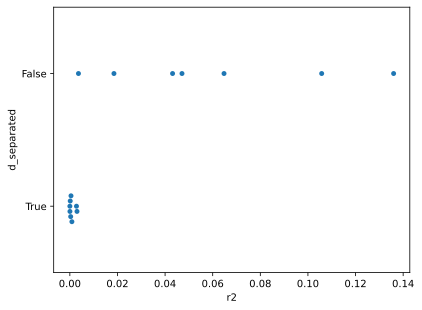

In [11]:
sns.swarmplot(data=param_df, y="d_separated", x="r2", orient="h")
plt.show()

In the following, we estimate parameter values for a linear SCM using backdoor adjustment

In [12]:
edge_parameters = get_single_door(example_graph, df)
edge_parameters

{(V1, V2): 0.8005952013593619,
 (V1, V4): 0.20880423964161526,
 (V2, V5): 0.19357571661445203,
 (V4, V5): 0.18642189085781272,
 (V4, V6): 0.40601462647428244,
 (V5, V6): 0.5007715039068367,
 (V3, V5): 0.3957426492229755}

## Backdoor example

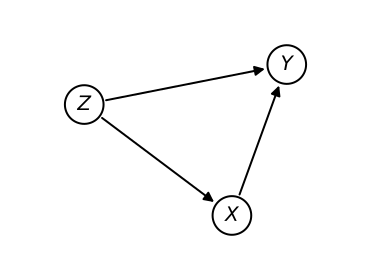

In [13]:
backdoor_example.graph.draw()

In [14]:
backdoor_example.graph.to_linear_scm_latex()

'\\begin{align*}Z &= \\epsilon_{Z} \\\\\n X &= Z \\beta_{Z,X} + \\epsilon_{X} \\\\\n Y &= X \\beta_{X,Y} + Z \\beta_{Z,Y} + \\epsilon_{Y} \\\\\\end{align*}'

In [15]:
backdoor_generators = {
    X: partial(uniform, low=-1.0, high=1.0),
    Y: partial(uniform, low=-2.0, high=2.0),
    Z: partial(normal, loc=0.0, scale=1.0),
}

In [16]:
backdoor_df, backdoor_fits = simulate(
    backdoor_example.graph, generators=backdoor_generators, trials=5000
)
backdoor_df

,Z,X,Y
0,0.156832,0.854023,-1.586419
1,-0.856190,0.452547,-0.503546
2,0.082370,0.769859,1.278156
3,0.086548,0.706248,-1.102110
4,-1.049070,0.239242,-2.092932
...,...,...,...
4995,1.016030,-0.679110,0.311297
4996,0.521026,-0.225085,1.391768
4997,0.102940,-0.710500,-0.324400
4998,-0.041803,-0.175323,1.856466


In [17]:
get_fits_df(backdoor_fits)

,parent,child,slope,intercept,r2,d_separated,d_sep_cond
0,Z,X,0.225544,-0.000161,0.132209,False,None
1,Z,Y,0.742898,-0.021943,0.292678,False,None
2,Y,X,0.609467,-0.041118,0.075794,False,None


In [18]:
backdoor_parameters = get_single_door(backdoor_example.graph, backdoor_df)
backdoor_parameters

{(Z, X): 0.22554437262952332,
 (Z, Y): 0.7428975020438258,
 (X, Y): 0.2005048199061129}

## Frontdoor example

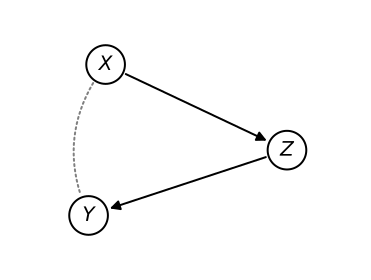

In [19]:
frontdoor_example.graph.draw()

In [20]:
frontdoor_example.graph.to_linear_scm_latex()

'\\begin{align*}X &= \\epsilon_{X} + \\gamma_{X,Y} \\\\\n Z &= X \\beta_{X,Z} + \\epsilon_{Z} \\\\\n Y &= Z \\beta_{Z,Y} + \\epsilon_{Y} + \\gamma_{X,Y} \\\\\\end{align*}'

In [21]:
frontdoor_generators = {
    X: partial(uniform, low=-1.0, high=1.0),
    Y: partial(uniform, low=-2.0, high=2.0),
    Z: partial(normal, loc=0.0, scale=1.0),
}

In [22]:
frontdoor_df, frontdoor_fits = simulate(
    frontdoor_example.graph, generators=frontdoor_generators, trials=5000
)
frontdoor_df

,X,Z,Y
0,0.921157,-0.055217,1.883134
1,0.031935,-0.257169,1.008251
2,-0.345371,-0.299066,-0.392274
3,0.110180,0.041193,0.061435
4,-0.188361,-0.037484,0.541029
...,...,...,...
4995,0.159687,-2.027436,0.050775
4996,0.984365,-1.138580,1.055860
4997,-0.330066,1.556705,0.274870
4998,-0.889061,0.099965,0.818456


In [23]:
get_fits_df(frontdoor_fits)

,parent,child,slope,intercept,r2,d_separated,d_sep_cond
0,Z,X,0.248891,0.011642,0.019977,False,None
1,Z,Y,0.100154,0.033683,0.007724,False,None
2,Y,X,0.032306,0.034854,0.000259,False,None


In [24]:
frontdoor_parameters = get_single_door(frontdoor_example.graph, frontdoor_df)
frontdoor_parameters

{(X, Z): 0.24889140650617492, (Z, Y): 0.09954944265542327}

## Napkin example

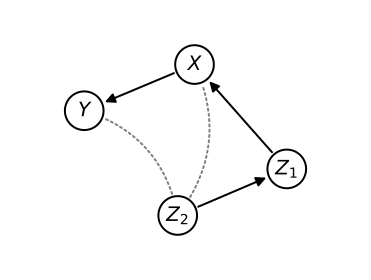

In [25]:
napkin_example.graph.draw()

In [26]:
napkin_example.graph.to_linear_scm_latex()

'\\begin{align*}{Z_{2}} &= \\epsilon_{{Z_{2}}} + \\gamma_{X,{Z_{2}}} + \\gamma_{Y,{Z_{2}}} \\\\\n {Z_{1}} &= \\beta_{{Z_{2}},{Z_{1}}} {Z_{2}} + \\epsilon_{{Z_{1}}} \\\\\n X &= \\beta_{{Z_{1}},X} {Z_{1}} + \\epsilon_{X} + \\gamma_{X,{Z_{2}}} \\\\\n Y &= X \\beta_{X,Y} + \\epsilon_{Y} + \\gamma_{Y,{Z_{2}}} \\\\\\end{align*}'

In [27]:
napkin_generators = {
    X: partial(uniform, low=-1.0, high=1.0),
    Y: partial(uniform, low=-2.0, high=2.0),
    Z1: partial(normal, loc=0.0, scale=1.0),
    Z2: partial(normal, loc=0.0, scale=1.0),
}

In [28]:
napkin_df, napkin_fits = simulate(napkin_example.graph, generators=napkin_generators, trials=5000)
napkin_df

,Z2,Z1,X,Y
0,-0.791446,-1.785951,-2.334628,-1.866428
1,0.974479,2.663290,1.834485,0.009675
2,1.551298,-0.051537,0.680645,1.134142
3,1.129496,0.383146,-0.202408,1.493882
4,-1.991145,-1.489580,-1.962975,0.315800
...,...,...,...,...
4995,-1.536213,-0.904328,0.194288,1.033672
4996,-0.493137,0.067708,1.039487,0.503009
4997,0.904584,-0.082942,-0.974222,0.511931
4998,-1.324994,-2.062396,-1.541053,0.094800


In [29]:
get_fits_df(napkin_fits)

,parent,child,slope,intercept,r2,d_separated,d_sep_cond
0,Z1,Z2,0.550195,0.007701,0.230864,False,None
1,Z1,X,0.845928,-0.000107,0.743141,False,None
2,Y,X,0.124140,0.011093,0.014562,False,None
3,X,Z2,0.372003,-0.008733,0.174729,False,None
4,Y,Z1,0.105414,0.002269,0.011324,True,"(X, Z2)"
5,Y,Z2,0.037760,-0.008112,0.001905,False,None


In [30]:
napkin_parameters = get_single_door(napkin_example.graph, napkin_df)
napkin_parameters

{(Z2, Z1): 0.5501950644148419, (Z1, X): 0.8435963905547348}